In [1]:
import tensorflow as tf
import keras
from construct_dataset import *
import glob
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import random
import numpy as np
import matplotlib as mpl

print(tf.__version__)
print(keras.__version__)

2024-10-15 17:00:17.968048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 17:00:17.971429: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:00:18.127951: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:00:18.563407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 17:00:21.772680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

2.16.1
3.5.0


In [2]:
batch_size = 512
input_length  = 124
c = [c for c in matplotlib.colors.CSS4_COLORS]

In [3]:
path_ = '/lustre/fswork/projects/rech/psl/upu87pm/Data_driven_DYNAMICO/saved/normalization_factors/lr/first_dataset/'

col1_mean_GLOB = np.load(path_ + 'col1_mean_GLOB.npy')
col1_std_GLOB = np.load(path_ + 'col1_std_GLOB.npy')

col1_mean_GLOB_o = np.load(path_ + 'col1_mean_GLOB_o.npy')
col1_std_GLOB_o = np.load(path_ + 'col1_std_GLOB_o.npy')

col1_std_GLOB[col1_std_GLOB==0.] = 1e-20
col1_std_GLOB_o[col1_std_GLOB_o==0.] = 1e-20

# Loading low res test data

In [5]:
path_for_glob = '/lustre/fsn1/projects/rech/psl/upu87pm/low_res_data/scoring_set/'

ncol = 384

In [6]:
f_mli = glob.glob(path_for_glob + 'input_*.npy')
f_mli = np.array(sorted(f_mli))
print(len(f_mli), "files available")
n = np.load(f_mli[0]).shape[0]
idx_s = list(range(n//4))   #to dowsample by 10
n_ = len(idx_s)

160 files available


In [7]:
idx_f = list(range(0,80))
n_samples = len(idx_f)*n_
print("using ", len(idx_f), "files for test set, each of them contains ", n_, "samples ==> ", len(idx_f)*n_, "samples")

using  80 files for test set, each of them contains  15744 samples ==>  1259520 samples


In [8]:
n_samples = n_samples - n_samples%ncol
print("test data correspond to ", n_samples//ncol , " timesteps")
ds_test_ = np.concatenate([np.load(f_mli[i])[idx_s, :] for i in idx_f])[:n_samples]
y_test = np.concatenate([np.load(f_mli[i].replace('input', 'target'))[idx_s, :] for i in idx_f])[:n_samples]

test data correspond to  3280  timesteps


In [9]:
ds_test  = (ds_test_ - col1_mean_GLOB)/ col1_std_GLOB 
ds_test.shape

(1259520, 556)

# Loadin model

In [4]:
path = '../saved/models/Dense/'
Model_name = ['Dense']
Model_filepath = [path + 'Densemodel1_epoch_99.keras']
#Model_filepath = ['../../RUNDIR/saved_models/Dense/Densemodel2_epoch_99.keras']

custom_objects = {
        'R2Score': tf.keras.metrics.R2Score(class_aggregation="variance_weighted_average"),
    }

Model = [keras.models.load_model(model_filepath, custom_objects) for model_filepath in Model_filepath]

2024-10-15 17:00:29.072287: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
P_test_ = [Model[i].predict(ds_test, batch_size=batch_size) for i in range(len(Model))]

2460/2460 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


In [12]:
P_test = [P_test_[i] * col1_std_GLOB_o + col1_mean_GLOB_o for i in range(len(Model))]

In [13]:
mpl.rcParams['figure.figsize'] = [9., 4.]

In [24]:
c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

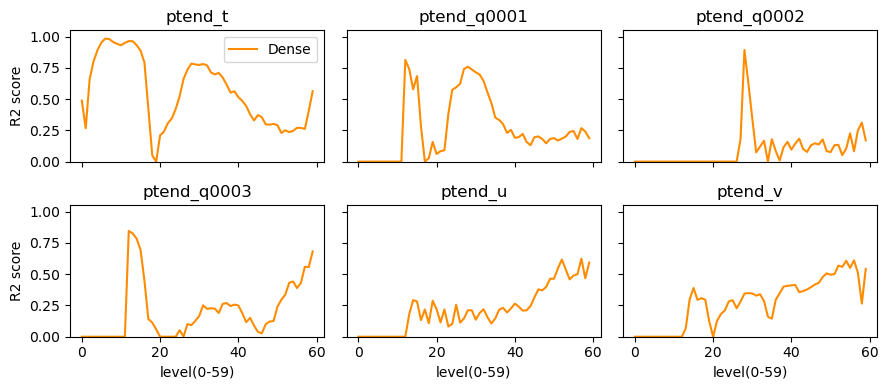

In [15]:
fig, axs = plt.subplots(2, 3)
L  = ['ptend_t', 'ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_u', 'ptend_v']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

for ivar in range(0,360,60):
    for j in range(len(Model)):
        scores_valid = np.array([metrics.r2_score(y_test[:, i], P_test[j][:, i]) for i in range(ivar, ivar+60)])
        axs[ivar//60//3, ivar//60%3].plot(scores_valid.clip(0, 1),c_list[j], label = Model_name[j])
        axs[ivar//60//3, ivar//60%3].set_ylim([0, 1.05])
        axs[ivar//60//3, ivar//60%3].set_title(L[ivar//60])
        axs[ivar//60//3, ivar//60%3].set_yticks(np.arange(-0.0,1.25,0.25))
        axs[0,0].legend()



for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='R2 score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()

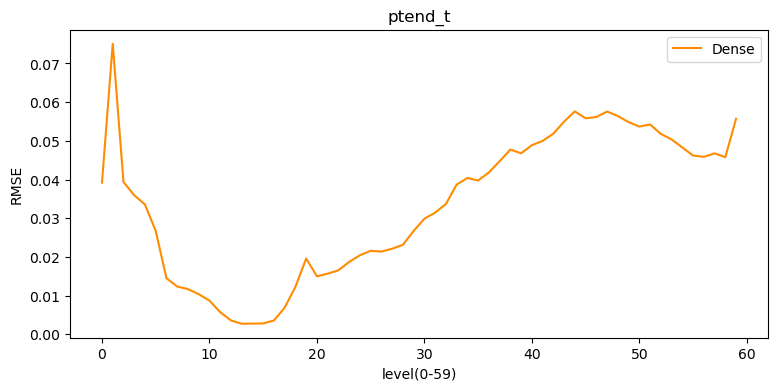

In [16]:
fig, axs = plt.subplots(1, 1)
L  = ['ptend_t']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

for j in range(len(Model)):
    scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(60)])
    #scores_valid = np.array([metrics.mean_squared_error(y_test[:, i], P_test[j][:, i]) for i in range(60)])
    axs.plot(scores_valid, c_list[j], label = Model_name[j])
    axs.set_title(L[0])
    axs.legend()

axs.set(xlabel='level(0-59)', ylabel='RMSE')
axs.label_outer()

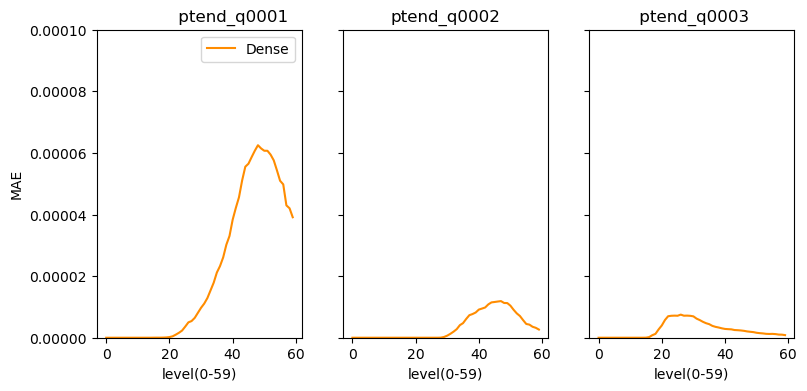

In [20]:
fig, axs = plt.subplots(1, 3)
L  = ['             ptend_q0001', 'ptend_q0002',' ptend_q0003']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]


for ivar in range(60,240,60):
    for j in range(len(Model)):
        #scores_valid = np.array([metrics.mean_absolute_error(y_test[:, i], P_test[j][:, i]) for i in range(ivar, ivar+60)])
        scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(ivar, ivar+60)])
        axs[ivar//60 -1].plot(scores_valid.clip(0, 1), c_list[j], label = Model_name[j])
        axs[ivar//60 -1].set_ylim([0, 1*1e-4])
        axs[ivar//60 -1].set_title(L[ivar//60 - 1])
        axs[0].legend()


for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='MAE')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

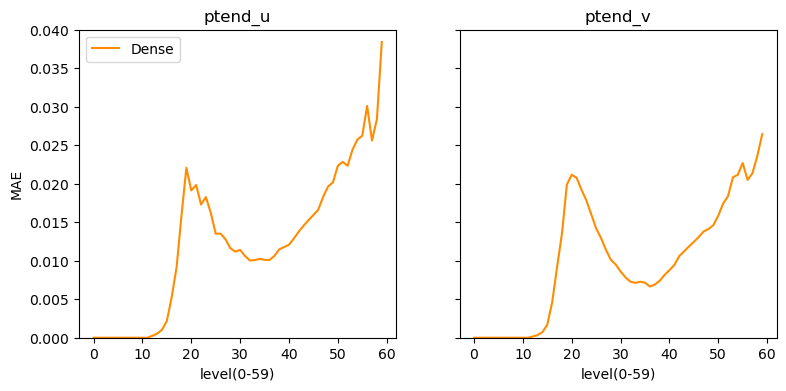

In [22]:
fig, axs = plt.subplots(1, 2)
L  = ['ptend_u', 'ptend_v']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]


for ivar in range(240,360,60):
    for j in range(len(Model)):
        scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(ivar, ivar+60)])
        axs[ivar//60%2].plot(scores_valid.clip(0, 1), c_list[j], label = Model_name[j])
        axs[ivar//60%2].set_ylim([0, 4*1e-2])
        axs[ivar//60%2].set_title(L[ivar//60 - 4])
        axs[0].legend()


for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='MAE')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [23]:
np.save('y_lr.npy', y_test)
for i in range(len(Model)): np.save('p_lr_'+Model_name[i]+'.npy', P_test[i]) 

In [24]:
del y_test
del P_test

# map

In [25]:
import psyplot
import psyplot.project as psy
from psy_maps.plotters import FieldPlotter
import matplotlib as mpl

In [26]:
grid_b = '../../_hyrid_climate_modelling_/BuildGrid/grid_lr_with_boundaries.nc'

In [27]:
psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False
mpl.rcParams['figure.figsize'] = [4., 3.]

In [28]:
var = 'ptend_t'

In [29]:
ds = npy_toxarray(['y_lr.npy'], grid_b, var = var)
Pred = [npy_toxarray(['p_lr_'+Model_name[i]+'.npy'], grid_b, var = var) for i in range(len(Model))]

nvar =  60
time counter =  3280
shape;  (3280, 60, 384)


/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvar =  60
time counter =  3280
shape;  (3280, 60, 384)


In [32]:
import warnings
warnings.filterwarnings('ignore')

time_counter = 50
inf = -2e-3
sup = 2e-3
nc = 31
lev = 10


inf = min(ds[var][time_counter][lev].min(), Pred[0][var][time_counter][lev].min())
sup = max(ds[var][time_counter][lev].max(), Pred[0][var][time_counter][lev].max())
b = max(abs(inf), abs(sup))

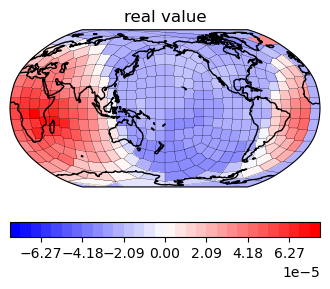

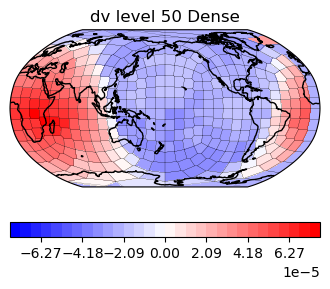

In [33]:
map_out = ds.psy.plot.mapplot(name=var, time_counter = time_counter, lev = lev, cmap = 'bwr', datagrid={'c': 'k', 'lw': 0.1}, projection='robin', bounds = np.linspace(-b,b,nc),
                             title = 'real value')
for i in range(len(Model)):
    map_out = Pred[i].psy.plot.mapplot(name=var, time_counter = time_counter, lev = lev, cmap = 'bwr', datagrid={'c': 'k', 'lw': 0.1}, projection='robin',
                                     bounds = np.linspace(-b,b,nc), title = 'dv level 50 '+Model_name[i])

# same for high resolution data

In [15]:
path_for_glob = '/lustre/fsn1/projects/rech/psl/upu87pm/high_res_data/scoring_set_hr/'

ncol = 21600

In [16]:
f_mli = glob.glob(path_for_glob + 'input_*.npy')
f_mli = np.array(sorted(f_mli))
print(len(f_mli), "files available")
n = np.load(f_mli[0]).shape[0]
idx_s = list(range(n//1))   #to dowsample by 10
n_ = len(idx_s)

320 files available


In [17]:
idx_f = list(range(0,20))
n_samples = len(idx_f)*n_
print("using ", len(idx_f), "files for test set, each of them contains ", n_, "samples ==> ", len(idx_f)*n_, "samples")

using  20 files for test set, each of them contains  21600 samples ==>  432000 samples


In [18]:
n_samples = n_samples - n_samples%ncol
print("test data correspond to ", n_samples//ncol , " timesteps")
ds_test_ = np.concatenate([np.load(f_mli[i])[idx_s, :] for i in idx_f])[:n_samples]
y_test = np.concatenate([np.load(f_mli[i].replace('input', 'target'))[idx_s, :] for i in idx_f])[:n_samples]

test data correspond to  20  timesteps


In [19]:
ds_test  = (ds_test_ - col1_mean_GLOB)/ col1_std_GLOB 
ds_test.shape

(432000, 556)

In [20]:
P_test_ = [Model[i].predict(ds_test, batch_size=batch_size) for i in range(len(Model))]

844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [21]:
P_test = [P_test_[i] * col1_std_GLOB_o + col1_mean_GLOB_o for i in range(len(Model))]

In [22]:
mpl.rcParams['figure.figsize'] = [9., 4.]

In [25]:
c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

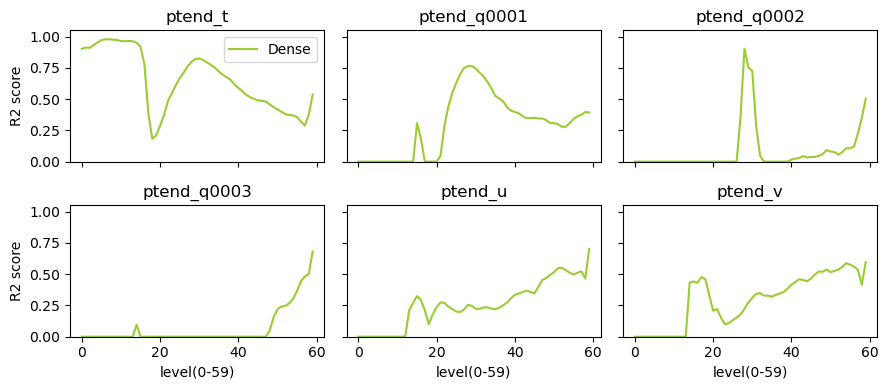

In [26]:
fig, axs = plt.subplots(2, 3)
L  = ['ptend_t', 'ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_u', 'ptend_v']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

for ivar in range(0,360,60):
    for j in range(len(Model)):
        scores_valid = np.array([metrics.r2_score(y_test[:, i], P_test[j][:, i]) for i in range(ivar, ivar+60)])
        axs[ivar//60//3, ivar//60%3].plot(scores_valid.clip(0, 1),c_list[j], label = Model_name[j])
        axs[ivar//60//3, ivar//60%3].set_ylim([0, 1.05])
        axs[ivar//60//3, ivar//60%3].set_title(L[ivar//60])
        axs[ivar//60//3, ivar//60%3].set_yticks(np.arange(-0.0,1.25,0.25))
        axs[0,0].legend()



for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='R2 score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.tight_layout()

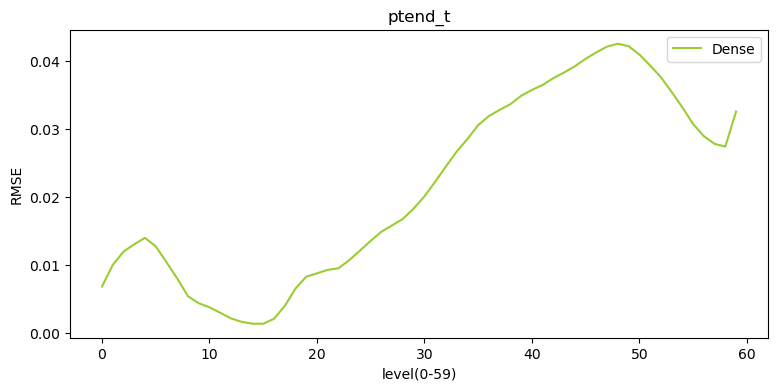

In [27]:
fig, axs = plt.subplots(1, 1)
L  = ['ptend_t']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]

for j in range(len(Model)):
    scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(60)])
    #scores_valid = np.array([metrics.mean_squared_error(y_test[:, i], P_test[j][:, i]) for i in range(60)])
    axs.plot(scores_valid, c_list[j], label = Model_name[j])
    axs.set_title(L[0])
    axs.legend()

axs.set(xlabel='level(0-59)', ylabel='RMSE')
axs.label_outer()

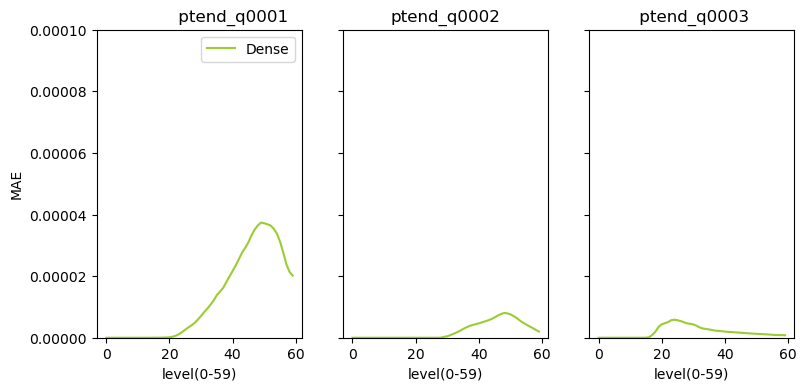

In [28]:
fig, axs = plt.subplots(1, 3)
L  = ['             ptend_q0001', 'ptend_q0002',' ptend_q0003']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]


for ivar in range(60,240,60):
    for j in range(len(Model)):
        #scores_valid = np.array([metrics.mean_absolute_error(y_test[:, i], P_test[j][:, i]) for i in range(ivar, ivar+60)])
        scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(ivar, ivar+60)])
        axs[ivar//60 -1].plot(scores_valid.clip(0, 1), c_list[j], label = Model_name[j])
        axs[ivar//60 -1].set_ylim([0, 1*1e-4])
        axs[ivar//60 -1].set_title(L[ivar//60 - 1])
        axs[0].legend()


for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='MAE')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

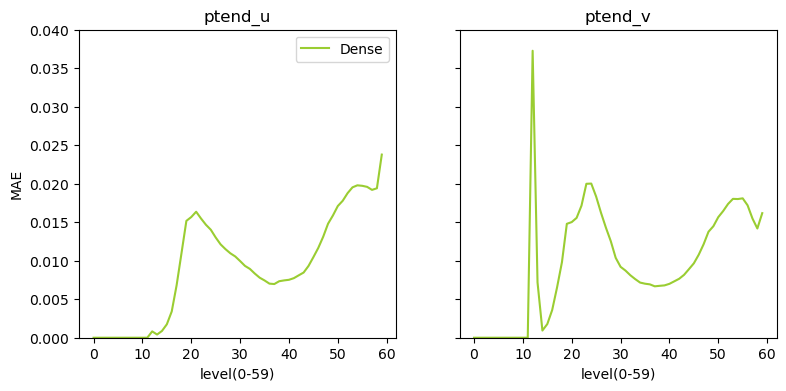

In [29]:
fig, axs = plt.subplots(1, 2)
L  = ['ptend_u', 'ptend_v']
#c_list = [ c[random.randint(0, len(c))] for i in range(len(Model))]


for ivar in range(240,360,60):
    for j in range(len(Model)):
        scores_valid = np.array([np.sqrt(np.sum((y_test[:, i] - P_test[j][:, i])**2)) for i in range(ivar, ivar+60)])
        axs[ivar//60%2].plot(scores_valid.clip(0, 1), c_list[j], label = Model_name[j])
        axs[ivar//60%2].set_ylim([0, 4*1e-2])
        axs[ivar//60%2].set_title(L[ivar//60 - 4])
        axs[0].legend()


for ax in axs.flat:
    ax.set(xlabel='level(0-59)', ylabel='MAE')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [30]:
np.save('y_hr.npy', y_test)
for i in range(len(Model)): np.save('p_hr_'+Model_name[i]+'.npy', P_test[i]) 

# then map

In [31]:
grid_b = '../../_hyrid_climate_modelling_/BuildGrid/grid_hr_with_boundaries.nc'

In [36]:
var = 'ptend_u'

In [37]:
ds = npy_toxarray(['y_hr.npy'], grid_b, var = var)
Pred = [npy_toxarray(np.load('p_hr_'+Model_name[i]+'.npy'), grid_b, var = var) for i in range(len(Model))]

ncol =  21600
nvar =  60
time counter =  20
shape;  (20, 60, 21600)
ncol =  21600
nvar =  60
time counter =  20
shape;  (20, 60, 21600)


In [40]:
import warnings
warnings.filterwarnings('ignore')

time_counter = 0
inf = -2e-3
sup = 2e-3
nc = 31
lev = 57


inf = min(ds[var][time_counter][lev].min(), Pred[0][var][time_counter][lev].min())
sup = max(ds[var][time_counter][lev].max(), Pred[0][var][time_counter][lev].max())
b = max(abs(inf), abs(sup))

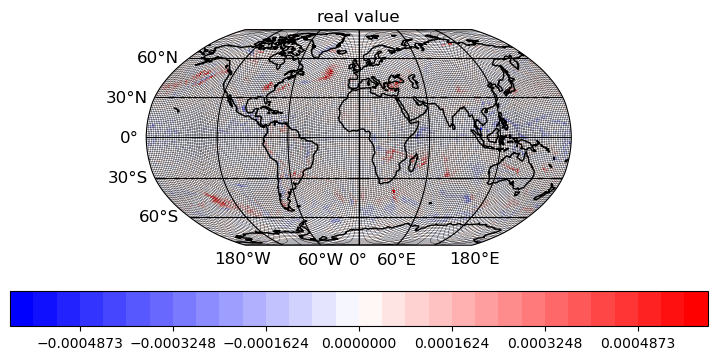

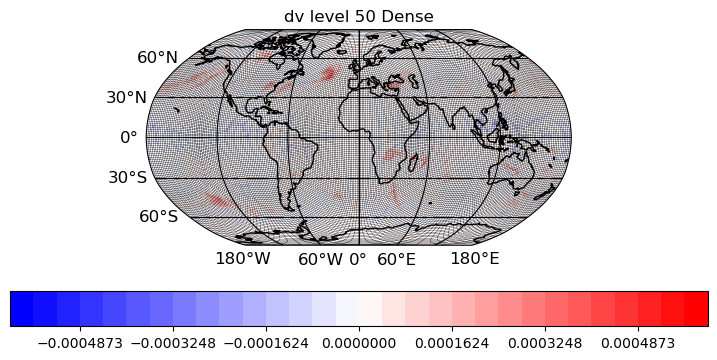

In [41]:
map_out = ds.psy.plot.mapplot(name=var, time_counter = time_counter, lev = lev, cmap = 'bwr', datagrid={'c': 'k', 'lw': 0.1}, projection='robin', bounds = np.linspace(-b,b,nc),
                             title = 'real value')
for i in range(len(Model)):
    map_out = Pred[i].psy.plot.mapplot(name=var, time_counter = time_counter, lev = lev, cmap = 'bwr', datagrid={'c': 'k', 'lw': 0.1}, projection='robin',
                                     bounds = np.linspace(-b,b,nc), title = 'dv level 50 '+Model_name[i])